--- RQ1 Analysis ---


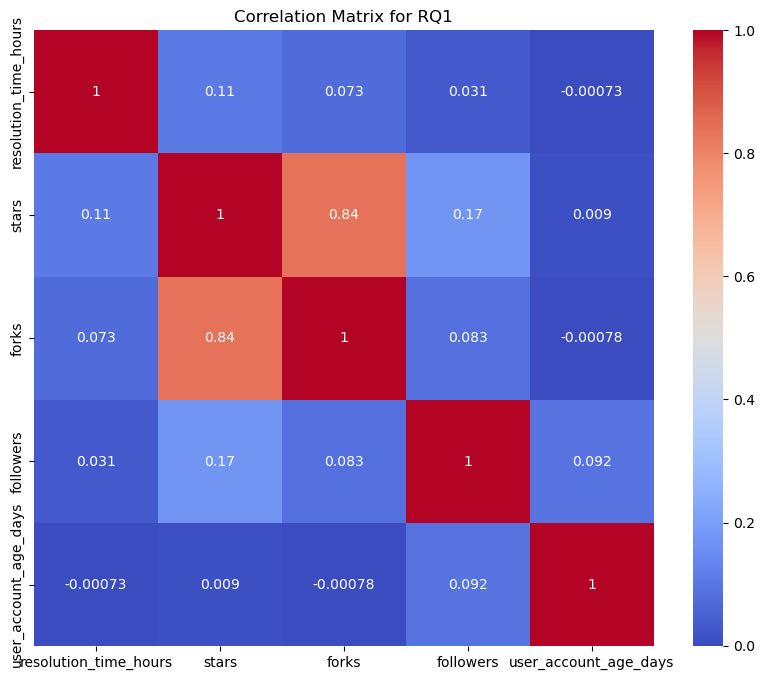

                              OLS Regression Results                             
Dep. Variable:     resolution_time_hours   R-squared:                       0.012
Model:                               OLS   Adj. R-squared:                  0.012
Method:                    Least Squares   F-statistic:                     2562.
Date:                   Tue, 25 Nov 2025   Prob (F-statistic):               0.00
Time:                           10:57:42   Log-Likelihood:            -4.4195e+06
No. Observations:                 817668   AIC:                         8.839e+06
Df Residuals:                     817663   BIC:                         8.839e+06
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------


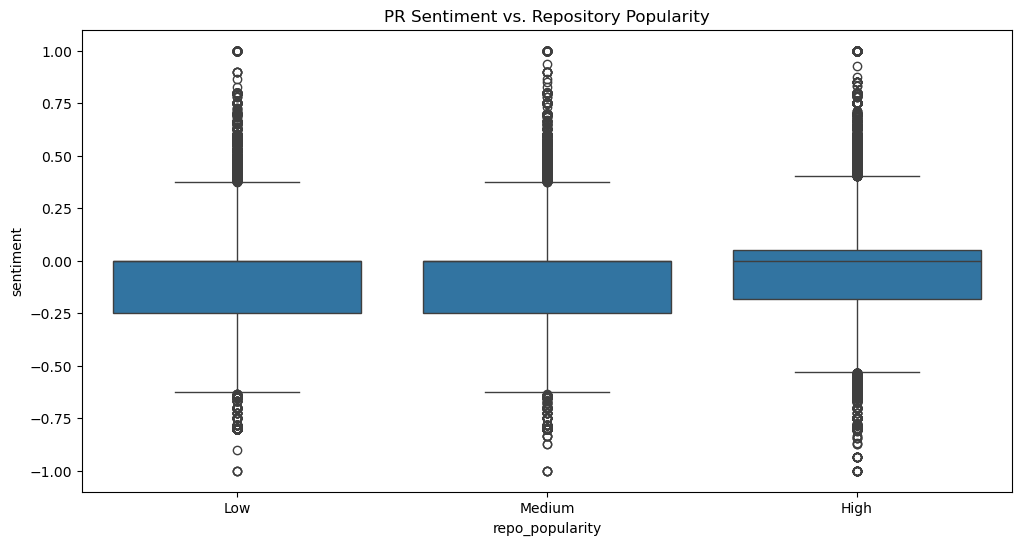

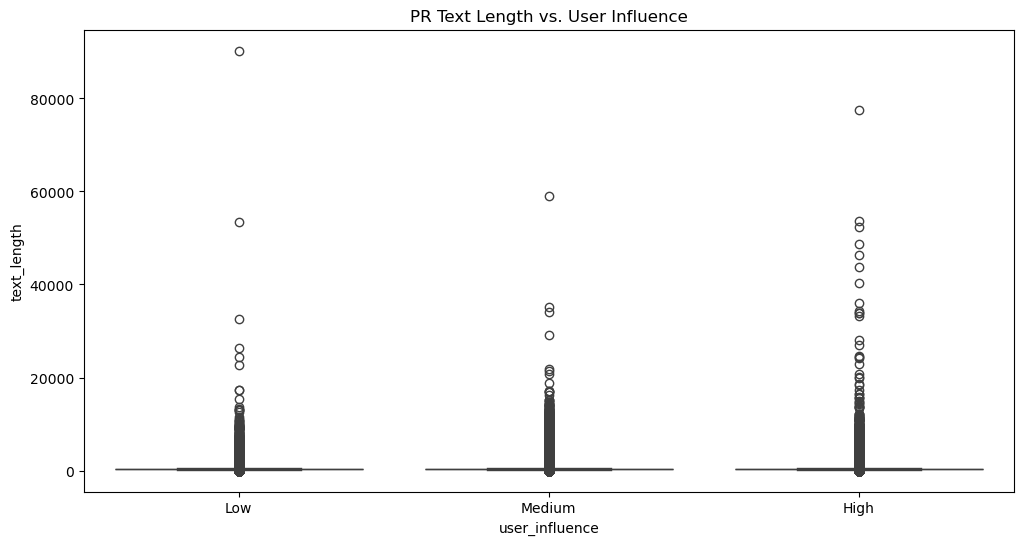


--- RQ3 Analysis ---
  agent_type task_type  is_merged
0      Human   Feature   0.791336
1      Human       Fix   0.872912
2      Human     Other   0.860255


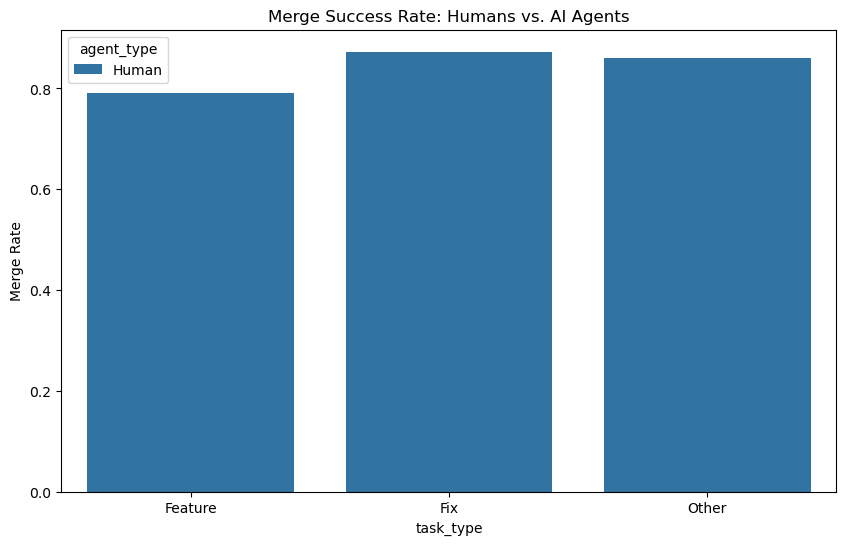

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from textblob import TextBlob

# --- 1. Data Loading ---
# Loading data as provided in your prompt
all_pr_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_pull_request.parquet")
all_repo_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_repository.parquet")
all_user_df = pd.read_parquet("hf://datasets/hao-li/AIDev/all_user.parquet")

# --- 2. Data Preprocessing & Merging  ---
# Ensure datetime conversion
all_pr_df['created_at'] = pd.to_datetime(all_pr_df['created_at'])
all_pr_df['closed_at'] = pd.to_datetime(all_pr_df['closed_at'])
all_pr_df['merged_at'] = pd.to_datetime(all_pr_df['merged_at'])
all_user_df['created_at'] = pd.to_datetime(all_user_df['created_at'])

# Rename columns to avoid collision during merge if necessary (e.g., id -> user_id)
# Assuming 'user_id' in PR matches 'id' in User, and 'repo_id' in PR matches 'id' in Repo
# Adjust column names based on actual dataframe .columns output if different.

# Merge PR with Repo data
df = all_pr_df.merge(all_repo_df, left_on='repo_id', right_on='id', suffixes=('_pr', '_repo'))

# Merge with User data (Creator of the PR)
df = df.merge(all_user_df, left_on='user_id', right_on='id', suffixes=('', '_user'))

# --- 3. Feature Engineering  ---

# Calculate Resolution Time (Hours)
df['resolution_time_hours'] = (df['closed_at'] - df['created_at']).dt.total_seconds() / 3600

# Calculate User Account Age (at time of PR creation) in days
df['user_account_age_days'] = (df['created_at'] - df['created_at_user']).dt.days

# NLP Features for RQ2 
def get_sentiment(text):
    if pd.isna(text): return 0
    return TextBlob(str(text)).sentiment.polarity

# Combining title and body for analysis
df['full_text'] = df['title'].fillna('') + ' ' + df['body'].fillna('')
df['text_length'] = df['full_text'].apply(len)
# Note: Sentiment analysis can be slow on large datasets. Test on a sample first if needed.
df['sentiment'] = df['full_text'].apply(get_sentiment)

# Task Type Classification for RQ3 [cite: 72]
def classify_task(title):
    title = str(title).lower()
    if 'fix' in title: return 'Fix'
    if 'feat' in title: return 'Feature'
    return 'Other'

df['task_type'] = df['title'].apply(classify_task)

# --- 4. Analysis by Research Question ---

# === RQ1: Repository/User Characteristics vs. Resolution Time [cite: 58, 66] ===
print("--- RQ1 Analysis ---")
# Filter for closed PRs only
rq1_data = df[df['state'] == 'closed'].dropna(subset=['resolution_time_hours', 'stars', 'forks', 'followers', 'user_account_age_days'])

# Visualization: Correlation Matrix
corr_cols = ['resolution_time_hours', 'stars', 'forks', 'followers', 'user_account_age_days']
plt.figure(figsize=(10, 8))
sns.heatmap(rq1_data[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for RQ1')
plt.show()

# OLS Regression
X = rq1_data[['stars', 'forks', 'followers', 'user_account_age_days']]
X = sm.add_constant(X)
y = rq1_data['resolution_time_hours']
model_rq1 = sm.OLS(y, X).fit()
print(model_rq1.summary())


# === RQ2: Text Characteristics vs. Popularity/Influence [cite: 59, 68] ===
print("\n--- RQ2 Analysis ---")
# Binning Repositories by Popularity (Stars) and Users by Influence (Followers)
df['repo_popularity'] = pd.qcut(df['stars'].rank(method='first'), q=3, labels=['Low', 'Medium', 'High'])
df['user_influence'] = pd.qcut(df['followers'].rank(method='first'), q=3, labels=['Low', 'Medium', 'High'])

# Compare Sentiment across groups
plt.figure(figsize=(12, 6))
sns.boxplot(x='repo_popularity', y='sentiment', data=df)
plt.title('PR Sentiment vs. Repository Popularity')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='user_influence', y='text_length', data=df)
plt.title('PR Text Length vs. User Influence')
plt.show()


# === RQ3: Human vs. AI Agent Merge Rates [cite: 60, 71] ===
print("\n--- RQ3 Analysis ---")
# Identify AI Agents vs Humans
# Assuming 'agent' column exists as per proposal. If not, you may need to filter by 'user_type' or specific bot names.
# For this code, we assume a boolean or categorical column 'is_bot' or 'agent' exists.
# If explicit 'agent' column is missing, check 'type' in user df (often 'User' vs 'Bot').
if 'type' in df.columns:
    df['agent_type'] = df['type'].apply(lambda x: 'AI/Bot' if x == 'Bot' else 'Human')
else:
    # Placeholder logic if specific column is unknown
    df['agent_type'] = 'Human' 

# Calculate Merge Success Rate
df['is_merged'] = df['merged_at'].notna()

rq3_grouped = df.groupby(['agent_type', 'task_type'])['is_merged'].mean().reset_index()
print(rq3_grouped)

# Visualization
plt.figure(figsize=(10, 6))
sns.barplot(x='task_type', y='is_merged', hue='agent_type', data=rq3_grouped)
plt.title('Merge Success Rate: Humans vs. AI Agents')
plt.ylabel('Merge Rate')
plt.show()